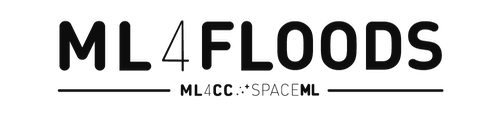

# Tutorial 1: Train a Flood Extent segmentation model using the WorldFloods dataset

## Step 0: Notebook setup
    - Configure notebook basics
    - Configure GCP Credentials

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/creds/ML4CC_creds.json"

%load_ext autoreload
%autoreload 2

## Step 1: Setup Configuration file
    - Load configuration file from local device or gcs

In [2]:
from src.models.config_setup import get_default_config

# Set filepath to configuration files
config_fp = os.path.join(root, 'src/models/configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},
    'deploy': False,
    'experiment_name': 'worldfloods_demo_test',
    'gpus': '0',
 

## Step 1.a: Seed everything for reproducibility

In [3]:
from pytorch_lightning import seed_everything
# Seed
seed_everything(config.seed)

Global seed set to 12


12

## Step 1.b: Make it a unique experiment
    - 'experiment_name' is used to specify the folder in which to save models and associated files

In [4]:
config.experiment_name = 'worldfloods-notebook-training-demo'

## Step 2: Setup Dataloader
    - 'loader_type' can be one of 'local' which assumes the images are already saved locally, or 'bucket' which will load images directly from the bucket specified in 'bucket_id'

In [5]:
from src.models.dataset_setup import get_dataset

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/worldfloods/public/"
dataset = get_dataset(config.data_params)

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


## Step 3: Setup Model
     - 'train' = True specifies that we are training a new model from scratch
     - get_model(args) constructs a pytorch lightning model using the configuration specified in 'config.model_params'

In [6]:
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'all',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'num_channels': 13},
 'train': True,
 'test': True}

In [7]:
from src.models.model_setup import get_model

config.model_params.test = False
config.model_params.train = True
model = get_model(config.model_params)

## Step 4: Set up Weights and Biases Logger for experiment
    - We pass this to the model trainer in a later cell to automaticall log relevant metrics to wandb

In [8]:
import wandb
from pytorch_lightning.loggers import WandbLogger

# UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
wandb.login()
run = wandb.init()

# Specifies who is logging the experiment to wandb
config['wandb_entity'] = 'ml4floods'
# Specifies which wandb project to log to, multiple runs can exist in the same project
config['wandb_project'] = 'worldfloods-notebook-demo-project'

wandb_logger = WandbLogger(
    name=config.experiment_name,
    project=config.wandb_project, 
    entity=config.wandb_entity
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ipl_uv (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Step 5: Setup Lightning Callbacks
    - We implement checkpointing using the ModelCheckpoint callback to save the best performing checkpoints to local/gcs storage
    - We implement early stopping using the EarlyStopping callback to stop training early if there is no performance improvement after 10 epochs from the latest best checkpoint

In [9]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_dice_loss',
    mode='min',
    prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_dice_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

print(f"{config.model_params.model_folder}/{config.experiment_name}")

gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods-notebook-training-demo


/opt/miniconda3/envs/ml4floods/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods-notebook-training-demo/checkpoint exists and is not empty.
  warnings.warn(*args, **kwargs)


## Step 6: Setup Lighting Trainer
    -- Pytorch Lightning Trainer handles all the rest of the model training for us!
    -- add flags from 
    https://pytorch-lightning.readthedocs.io/en/0.7.5/trainer.html 

In [10]:
from pytorch_lightning import Trainer

config.gpus = '2'  # which gpu to use

config.model_params.hyperparameters.max_epochs = 4 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    distributed_backend=None,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=None,
    resume_from_checkpoint=None
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


# Start Training!

In [ ]:
trainer.fit(model, dataset)


  | Name    | Type         | Params
-----------------------------------------
0 | network | SimpleLinear | 42    
-----------------------------------------
42        Trainable params
0         Non-trainable params
42        Total params
0.000     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/miniconda3/envs/ml4floods/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  13%|█▎        | 815/6187 [06:11<40:48,  2.19it/s, loss=1.78, v_num=wene] 

## Step 7: Save trained model
    - Save model to local/gcs along with configuration file used to conduct training!

In [ ]:
from pytorch_lightning.utilities.cloud_io import atomic_save
from src.models.config_setup import save_json

# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model.pt")
torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, 'model.pt'))
wandb.save(os.path.join(wandb_logger.save_dir, 'model.pt'))
wandb.finish()

# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config.json"
save_json(config, config_file_path)

# All Done - Now head to the Model Inference Tutorial to see how your model performed!